In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

CONFIG

In [158]:
config = {
    # config for the neural network
    "nn": {
        "window": 50, # this is also the window, window size or entries used to predict the future price
        "nLayers": 2, # 2
        "neurons": 256, # 256
        "nFeatures": 5,
        "dropout": 0.3,
        "lossFunc": "huber_loss", #Huber looss is better to give outliers some weight but not too much, which can be good for predicting asset prices?
        "optimizer": "adam", # "adam"
        "layerType": LSTM, # could set it upt to be a list of the layers that need to be generated [LSTM LSTM] 2 hidden layers 
    },
    "data": {
        "ticker": "AMD", # "TSLA" "AMZN" "AAPL" "NVDA" "AMD"
        "offset": pd.DateOffset(years = 3, months = 0, days = 0),
        "lookahead": 2,
        "validation": 0.1, # percentage of training data to be used as validation
        "testSize": 0.1, # to test on 
        "scale": True,
        "scaler": preprocessing.MinMaxScaler(),
        "inputs": ['adjclose', 'volume', 'open', 'high', 'low'],
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64, # 64
        "num_epoch": 100, # 500
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}
# DISPLAY AROUGH ESTIMATE OF HOW MANY DAYS WILL BE USED FOR EACH SECTION
damping = 0.9 # some extra damping for extra days that data isn't collected

offset = config["data"]["offset"]
ts1 = pd.Timestamp('2023-02-25')
ts2 = ts1 + offset
td = ts2 - ts1
days_offset = int(td.days/7*5*damping) # find out the roungh amount of days imported
print(f"{days_offset} Total days used will be roughly imported\n")
print(f"{days_offset* (1-config['data']['validation']-config['data']['testSize'])} Days used for training")
print(f"{days_offset*config['data']['validation']} Days used for validation")
print(f"{days_offset*config['data']['testSize']} Days used for testing")

704 Total days used will be roughly imported

563.2 Days used for training
70.4 Days used for validation
70.4 Days used for testing


Import all the required libraries for this proect
Keep in mind you have to install the following libraries first before this code can be run

pip install tensorflow pandas numpy matplotlib yahoo_fin scikit-learn

if the computer being used is an silicon apple chip then for tensorflow the following must be done

conda install -c apple tensorflow-deps
pip install tensorflow-macos
pip install tensorflow-metal # this is an optional but recommended

pip install pandas numpy matplotlib yahoo_fin scikit-learn

python -m pip install jupyter notebook -U

conda install -c conda-forge -y pandas jupyter


In [159]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, LSTM, Dense


"""
HERE mean_absolute_error CAN BE REPLACED BY mse?
Also need to have a look at bidirectional network and how that works and so forth

"""
def generateModel(
    window,
    n_layers=2,
    neurons=256,
    n_features=5,
    dropout=0.3,
    loss="mean_absolute_error",
    optimizer="rmsprop",
    layerType=LSTM
    ):
    # generate a keras model to linearly group a stasck of layers
    model = models.Sequential()
    # repeat for each layer
    for layer in range(n_layers):
        # check for first layer
        if layer == 0:
            """NEED TO FIGURE OUT THE DIFFERENE BETWEEN THEESE TWO LINES OF CODE, INPUT SHAPE AND BATCH INPUT SHAPE"""
            model.add(LSTM(neurons, return_sequences=True, input_shape=(window, n_features)))
            # model.add(layerType(neurons, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        # check for final layer
        elif layer == n_layers - 1:
            model.add(layerType(neurons, return_sequences=False))
        # middle/hidden layers
        else:
            model.add(layerType(neurons, return_sequences=True))

        # add dropout after each layer
        """ this layer helps prevent over fitting
        The Dropout layer randomly sets input units to 0
        with a frequency of rate at each step during training time,
        which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate)
        such that the sum over all inputs is unchanged."""
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    # compile the model once it has be compelted
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


Generate the model by setting up all the parameters:

adjclose, volume, open, high and low as the 5 inputs of the model

In [160]:
# create a model using the options in CONFIG
model = generateModel(
    config["nn"]["window"],
    config["nn"]["nLayers"],
    config["nn"]["neurons"],
    n_features= config["nn"]["nFeatures"],
    dropout= config["nn"]["dropout"],
    loss= config["nn"]["lossFunc"],
    optimizer= config["nn"]["optimizer"],
    layerType= config["nn"]["layerType"]
    )

# display the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 50, 256)           268288    
                                                                 
 dropout_20 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_21 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 793,857
Trainable params: 793,857
Non-trainable params: 0
_________________________________________________________________


Visualisze the model

In [161]:
# import
from tensorflow.keras import models, layers, utils, backend as K 
import matplotlib.pyplot as plt
import numpy as np
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            # radius=y_space/4.0
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/10, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

# visualize_nn(model, description=True, figsize=(10,8)) # 10 by 8

Importing the data to be used with the neural netowork

"get_data" from "stock_info" takes the arguments:
- ticker: case insensitive ticker of the desired stock/bond
- start_date: date you want the data to start from (mm/dd/yyyy)
- end_date: date you want the data to end (mm/dd/yyyy)
- index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
- interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

DATA LOADER

In [162]:
# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing

from collections import deque

def getData(
    ticker,
    offset
    ):
    # setup the start date and end date
    startDate = (datetime.now() - offset).date()
    endDate = datetime.now().date()
    # Get the data
    stocks = stock_info.get_data(ticker, startDate, endDate)
    # display how many days of data are being used for this
    print(f"Data is imported between {startDate} and the {endDate}, for a total of {len(stocks)} days of data")
    print(f"Each day contains the prices for: {stocks.columns}")
    return stocks

def setupData(
    stocks, # data to be reshaped
    window = 50, # the number of days used to predic the next value (window size or lookback perdiod)
    predAhead = 10, # the number of days ahead that you are tyring to predict
    validationSize = 0.1, # amount of data out of the training data to be used as validation
    testSize = 0.2, # the amount of data that will be  used for testing e.g. 0.2 -> 20%
    scale = True, # minmaxscaler
    scaler = preprocessing.MinMaxScaler(), # the scaler to be used
    inputs = ['adjclose', 'volume', 'open', 'high', 'low']
    ):
    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["raw"] = stocks.copy()

    """This is something that really needs to be fixed in the future"""
    # I HAVE TO COPY THE STOCKS SO THAT THE ORIGINAL ONES AREN'T RETURNED? WHAT IS THIS ABOUT
    stocks = stocks.copy()
    



    # should we scale down between 0 and 1? It can make analysis easier
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in inputs:
            # scale the columns
            stocks[column] = scaler.fit_transform(np.expand_dims(stocks[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        data["column_scaler"] = column_scaler

    # create input a variable with x and y
    x = []
    y = []
    ydates = []
    for i in range(len(stocks)-window-predAhead+1):
        x.append(np.array(stocks[inputs].values[i:i+window]))
        y.append(stocks["adjclose"].values[i+window+predAhead-1])
        ydates.append(stocks.index[i+window+1])
    # convert into numpy arrays
    x = np.array(x)
    y = np.array(y)

    # store x and y into the data dictionary
    data["x"] = x
    data["y"] = y
    data["ydates"] =  ydates

    # split the dataset into training & testing sets by date
    # make sure to convert to an integer so that it can be used for indexing
    trainSamples = int((1 - testSize - validationSize) * len(x))
    valSamples = int(validationSize * len(x))
    data["xtrain"] = x[:trainSamples]
    data["ytrain"] = y[:trainSamples]

    data["xval"] = x[trainSamples:trainSamples+valSamples]
    data["yval"] = y[trainSamples:trainSamples+valSamples]

    data["xtest"]  = x[trainSamples+valSamples:]
    data["ytest"]  = y[trainSamples+valSamples:]
    
    data["trainDates"] = ydates[:trainSamples]
    data["valDates"] = ydates[trainSamples:trainSamples+valSamples]
    data["testDates"] = ydates[trainSamples+valSamples:]

    return data

In [163]:
# download data form yt
stocks = getData(config["data"]["ticker"], config["data"]["offset"])
stocks.keys()

Data is imported between 2020-02-26 and the 2023-02-26, for a total of 756 days of data
Each day contains the prices for: Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')


Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [164]:
# process the data
data = setupData(stocks, config["nn"]["window"], config["data"]["lookahead"], config["data"]["validation"], config["data"]["testSize"], config["data"]["scale"], config["data"]["scaler"], config["data"]["inputs"])
data.keys()

print(f"{data.keys()}\n\nHere are the adjusted values downloaded:")

print(data.keys())

print(len(data["raw"]))
print(len(data["ydates"]))


dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])

Here are the adjusted values downloaded:
dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])
756
705


Plot the data imported form the stocks

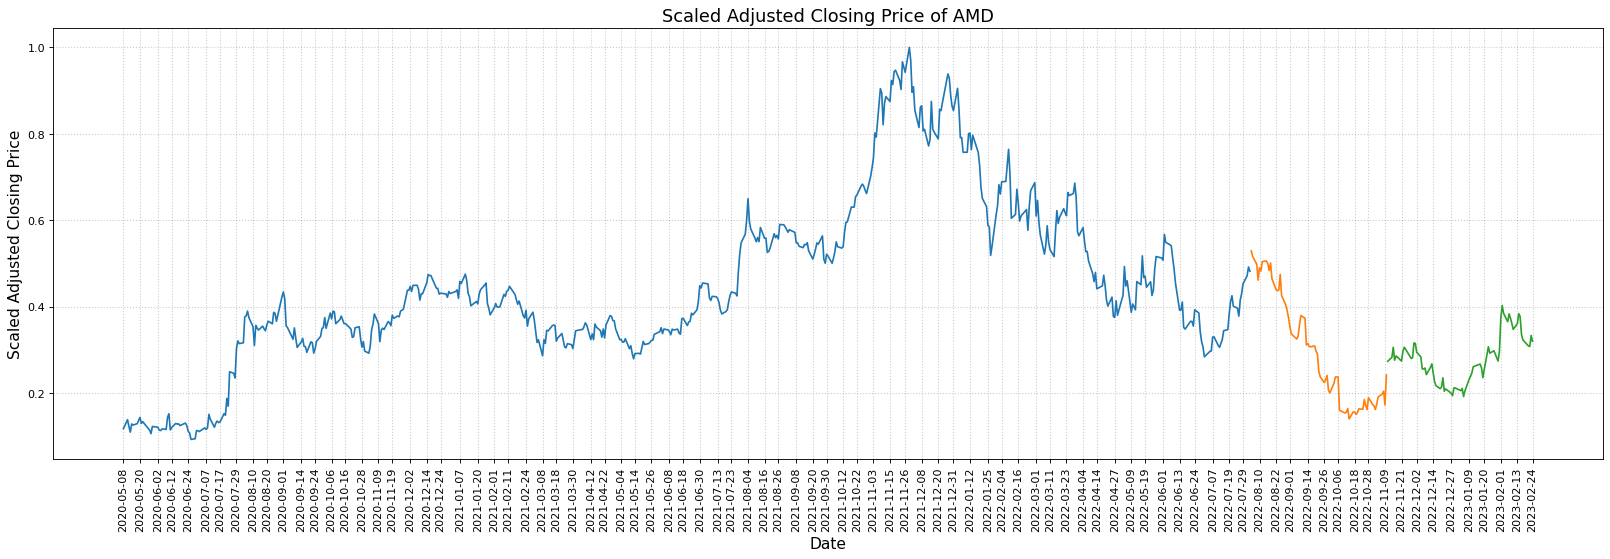

In [165]:
import matplotlib.pyplot as plt

plots = "trainDates ytrain,valDates yval,testDates ytest"
lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
for plot in plots.split(","):
    x, y = plot.split()
    plt.plot(data[f"{x}"], data[f"{y}"])
step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else None
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']}", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
# show the plot
plt.show()


Train the model

pip install tensorflow-macos==2.10
pip install tensorflow-metal==0.6

In [166]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

model_name = "trials"

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# Train the model by using the funciton fit
model.fit(data["xtrain"], data["ytrain"],
                    batch_size=config["training"]["batch_size"],
                    epochs=config["training"]["num_epoch"],
                    validation_data=(data["xval"], data["yval"]),
                    verbose=1) # should be able to chance verbose to 100 to display every 100 but doesn't seem to work
                    # callbacks=[checkpointer, tensorboard],


Epoch 1/100


2023-02-26 15:24:40.341299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:24:40.554869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:24:40.794530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:24:41.078470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:24:41.326855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.1663

2023-02-26 15:24:42.916324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:24:42.994184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:24:43.109123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 238ms/step - loss: 0.0265 - mean_absolute_error: 0.1663 - val_loss: 0.0019 - val_mean_absolute_error: 0.0518
Epoch 2/100
9/9 [==============================] - 0s 53ms/step - loss: 0.0041 - mean_absolute_error: 0.0701 - val_loss: 0.0011 - val_mean_absolute_error: 0.0365
Epoch 3/100
9/9 [==============================] - 0s 48ms/step - loss: 0.0022 - mean_absolute_error: 0.0507 - val_loss: 0.0035 - val_mean_absolute_error: 0.0736
Epoch 4/100
9/9 [==============================] - 0s 40ms/step - loss: 0.0020 - mean_absolute_error: 0.0481 - val_loss: 0.0011 - val_mean_absolute_error: 0.0384
Epoch 5/100
9/9 [==============================] - 0s 45ms/step - loss: 0.0016 - mean_absolute_error: 0.0433 - val_loss: 0.0013 - val_mean_absolute_error: 0.0405
Epoch 6/100
9/9 [==============================] - 0s 39ms/step - loss: 0.0017 - mean_absolute_error: 0.0445 - val_loss: 0.0012 - val_mean_absolute_error: 0.0399
Epoch 7/100
9/9 [======================

Plot the results

2023-02-26 15:25:19.439179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:25:19.505438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-26 15:25:19.626583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 28ms/step


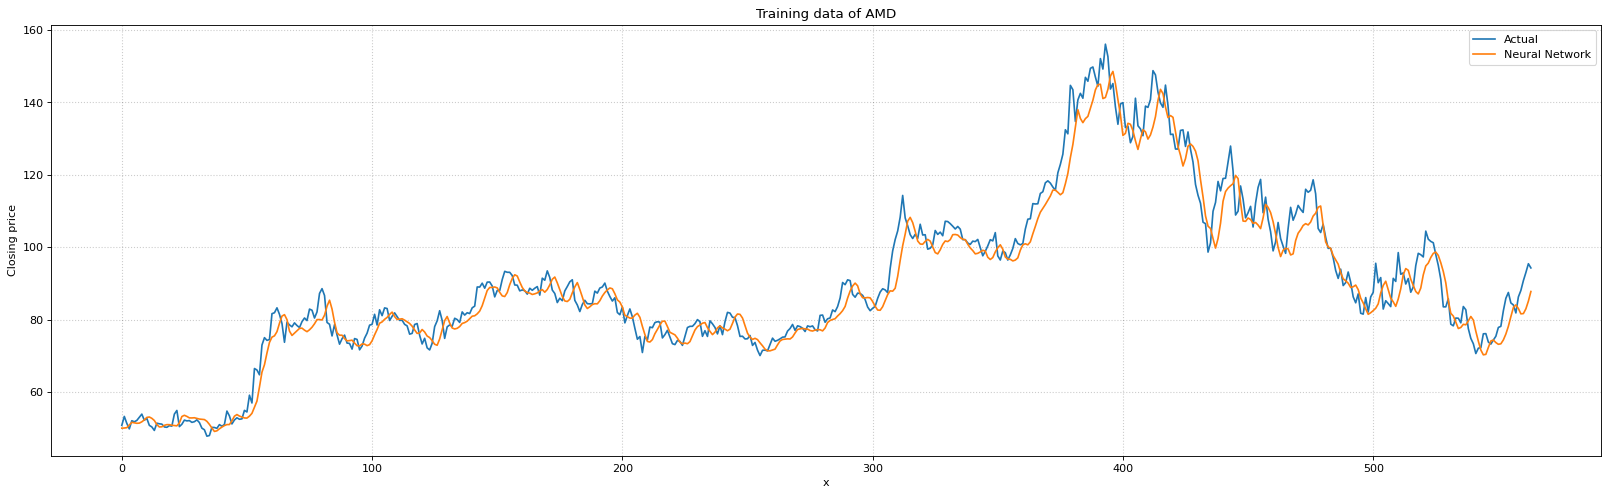

3/3 [==============================] - 0s 78ms/step


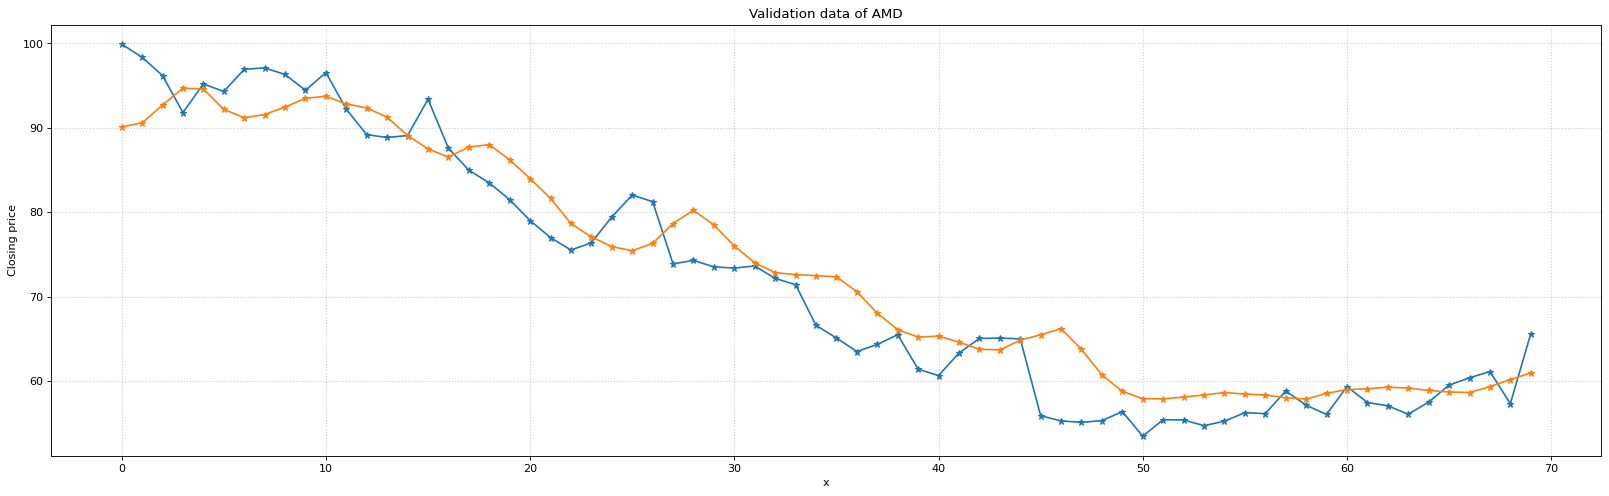

3/3 [==============================] - 0s 83ms/step


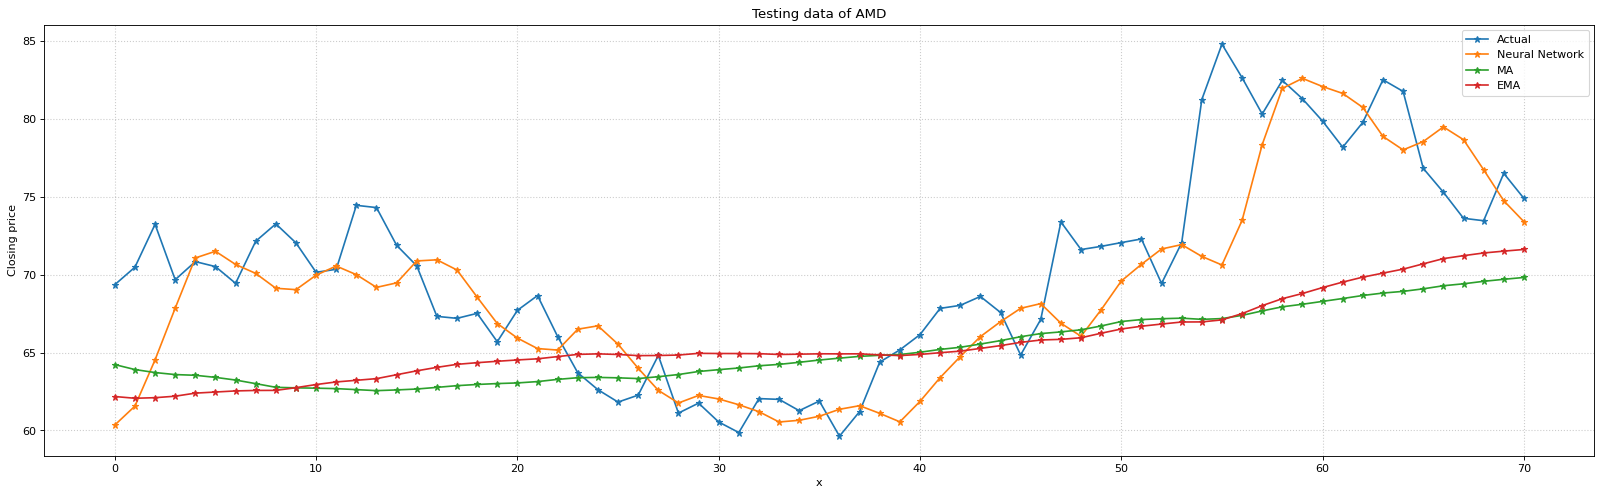

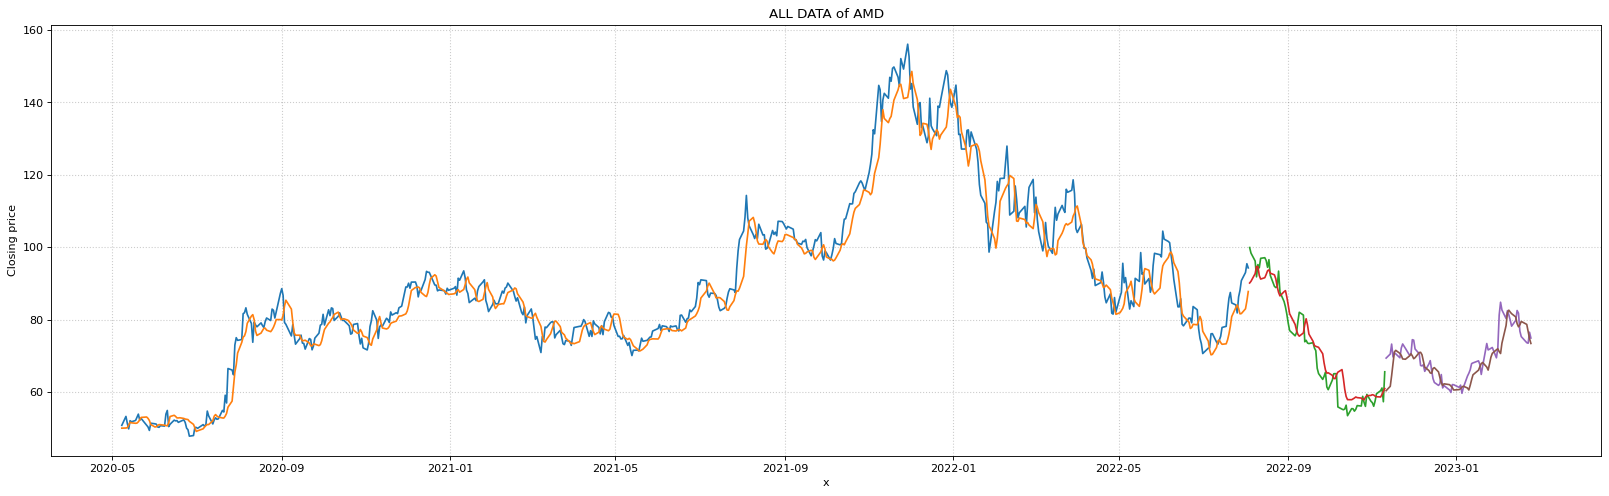

In [167]:
# plot the results
# TRAINING DATA
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
pred_ytrain = model.predict(data["xtrain"])
ytrain = data["ytrain"]
# scaler = config["data"]["scaler"]
pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))
plt.plot(ytrain)
plt.plot(pred_ytrain)
plt.title(f"Training data of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.legend("Actual,Neural Network".split(","))
plt.show()

# VALIDATION DATA
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
pred_yval = model.predict(data["xval"])
yval = data["yval"]
# scaler = config["data"]["scaler"]
pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))
plt.plot(yval, "*-") # actual data
plt.plot(pred_yval, "*-")
plt.title(f"Validation data of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()

# TEST DATA
# calcualte the price using a simple moving average
pred_MA = np.mean(data["xtest"], axis = 1)
pred_MA = pred_MA[:, 0] # take only the adjclose price out
pred_MA = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_MA, axis=0)))
# calculate the price using exponential moving average
pred_EMA = data["xtest"][:, :, 0] # only take the 
pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
weights = np.exp(np.linspace(-1, 0, config["nn"]["window"]))
weights /= weights.sum()
pred_EMA = pred_EMA@weights
# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
pred_ytest = model.predict(data["xtest"])
ytest = data["ytest"]
# scaler = config["data"]["scaler"]
pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))
plt.plot(ytest, "*-") # actual data
plt.plot(pred_ytest, "*-") # prediction made by neural network
plt.plot(pred_MA, "*-")
plt.plot(pred_EMA, "*-")
plt.title(f"Testing data of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.legend("Actual,Neural Network,MA,EMA".split(","))
plt.show()

# ALL 3 TOGETHER
# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
plt.plot(data["trainDates"],ytrain) # train data
plt.plot(data["trainDates"], pred_ytrain)
plt.plot(data["valDates"], yval) # val data
plt.plot(data["valDates"], pred_yval)
plt.plot(data["testDates"], ytest) # test data
plt.plot(data["testDates"], pred_ytest)
plt.title(f"ALL DATA of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()



 RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %) will be our current model evaluation metrics. Both are useful measures of forecast accuracy. 

In [207]:
#### Calculate the metrics RMSE and MAPE ####
def calc_mse(y_true, y_pred):
    mse = np.mean((y_true-y_pred)**2)
    # print(f"{mse:.2f} (MSE)")
    return mse

def calc_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    # print(f"{rmse:.2f} (RMSE)")
    return rmse

def calc_mae(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mae = np.mean(np.abs((y_true-y_pred) / y_true))
    # print(f"{mae:.2f} (MAE)")
    return mae

def calc_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    This can also be MAE if the *100 is removed to make it into the mean absolute error
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100
    # print(f"{mape:.2f} (MAPE)")
    return mape

# compare all the following data
pairs = [[ytrain, pred_ytrain, 'Training NN'],
         [yval, pred_yval, 'Validation NN'],
         [ytest, pred_ytest, 'Testing NN'],
         [ytest, pred_MA, 'Testing MA'],
         [ytest, pred_EMA, 'Testing EMA']
         ]

d = {}
for pair in pairs:
    d[pair[2]] = []
    d[pair[2]].append(calc_mse(pair[0], pair[1]))
    d[pair[2]].append(calc_rmse(pair[0], pair[1]))
    d[pair[2]].append(calc_mae(pair[0], pair[1]))
    d[pair[2]].append(calc_mape(pair[0], pair[1]))

df = pd.DataFrame(data=d)
df.index = ['MSE', 'RMSE', 'MAE', 'MAPE']
df

,Training NN,Validation NN,Testing NN,Testing MA,Testing EMA
MSE,24.003289,17.802223,15.864825,53.568821,51.430539
RMSE,4.899315,4.219268,3.983067,7.319072,7.171509
MAE,0.039397,0.049212,0.041394,0.081658,0.080985
MAPE,3.939715,4.921232,4.139386,8.165793,8.098546


Trading stocks

,Neural Netowrk,Moving Average,Exp Moving Average
Percentage,-23.43%,-2.49%,-9.72%
Buy in,"£ 1,000.00","£ 1,000.00","£ 1,000.00"
Cash out,£ 765.74,£ 975.05,£ 902.84
14.0 weeks profit,£ -234.26,£ -24.95,£ -97.16
Profit per month,£ -101.86,£ -10.85,£ -42.24


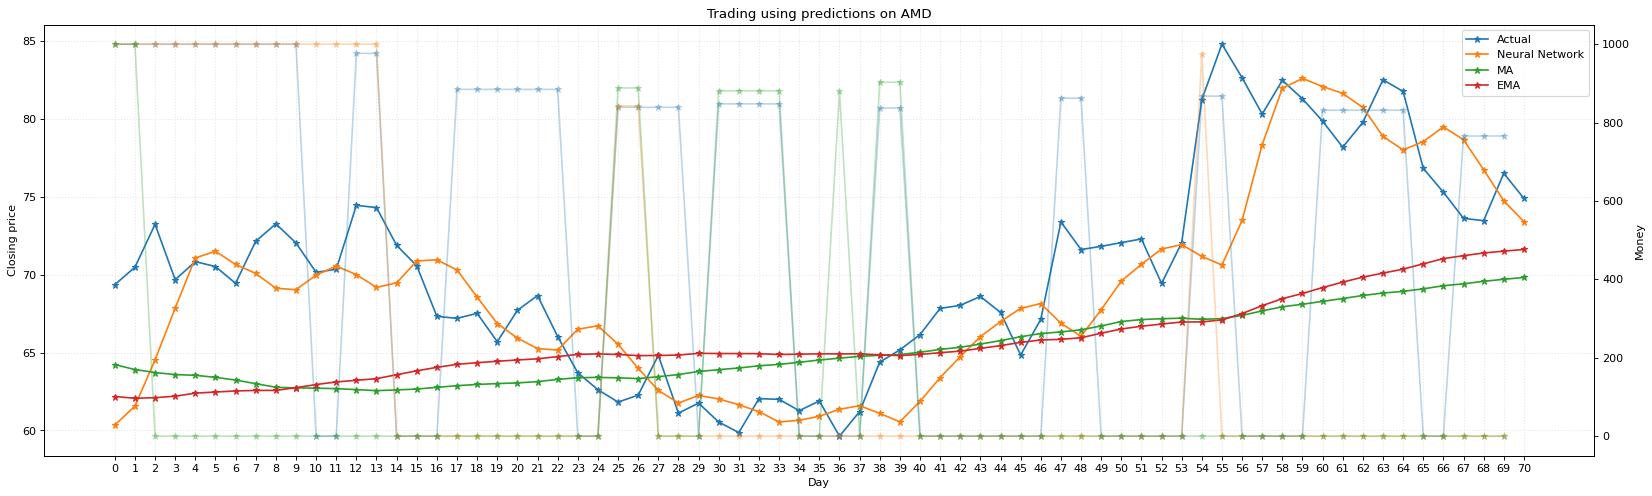

In [248]:
def trader(money, actual, predictions):
    owned_shares = 0
    history = [money]
    
    for i in range(len(predictions)-2):
        # keep track of what is owned
        history.append(money)

        # find out the prices
        # prev_price, curr_price, next_price = actual[i], actual[i+1], predictions[i+2]
        prev_price, curr_price, next_price = predictions[i], predictions[i+1], predictions[i+2]
        # buy
        if prev_price > curr_price and next_price > curr_price:
            if money == 0:
                # print(f"Can't buy {money, owned_shares}")
                continue
            # work out how many shares it buys
            owned_shares = money/actual[i+1]
            money = 0
            # print(f'buy {money, owned_shares}')
        # sell
        elif prev_price < curr_price and next_price < curr_price:
            if owned_shares == 0:
                # print(f"Can't sell {money, owned_shares}")
                continue
            money = owned_shares*actual[i+1]
            owned_shares = 0
            # print(f'sell {money, owned_shares}')
        # hold
        else:
            # print('do nothing')
            continue
    
    return history

def calc_profit(money_history, initial_money):
    # find the last value that wasn't 0
    for i in reversed(range(len(money_history))):
        if money_history[i] != 0:
            # the final value of money
            break # money_history[i] is the final value that isn't 0
    money_made = money_history[i]-initial_money
    percentage = money_made/initial_money*100
    spacing = 0
    spacer = "."
    stats = [f"{percentage:.2f}%".rjust(spacing, spacer),
         f"£ {initial_money:,.2f}".rjust(spacing, spacer),
         f"£ {money_history[i]:,.2f}".rjust(spacing, spacer),
         f"£ {money_made:,.2f}".rjust(spacing, spacer),
         f"£ {money_made/(len(money_history)/30.437):,.2f}".rjust(spacing, spacer)]
    return stats

# initial, final = 40, -1
# ytest = ytest[initial:final]
# pred_ytest = pred_ytest[initial:final]
# pred_MA = pred_MA[initial:final]
# pred_EMA = pred_EMA[initial:final]

initial_money = 1000
alpha = 0.3
nn_money = trader(initial_money, ytest, pred_ytest)
ma_money = trader(initial_money, ytest, pred_MA)
ema_money = trader(initial_money, ytest, pred_EMA)
# calcualte and display the results of the trader
d = {"Neural Netowrk": calc_profit(nn_money, initial_money),
     "Moving Average": calc_profit(ma_money, initial_money),
     "Exp Moving Average": calc_profit(ema_money, initial_money)
     }
df = pd.DataFrame(d, index = ['Percentage', 'Buy in', 'Cash out', f"{len(nn_money)/5} weeks profit", 'Profit per month'])
display(df) # display the dataframe

# plot the results
fig, ax1 = plt.subplots(figsize=(25, 7), dpi=80)
ax1.plot(ytest, "*-") # actual data
ax1.plot(pred_ytest, "*-") # prediction made by neural network
ax1.plot(pred_MA, "*-")
ax1.plot(pred_EMA, "*-")
ax1.legend("Actual,Neural Network,MA,EMA".split(","))
ax1.set_ylabel("Closing price")
# create a second axis
ax2 = ax1.twinx()
ax2.plot(nn_money, "*-", alpha = alpha) # money over time
ax2.plot(ma_money, "*-", alpha = alpha) # money over time
ax2.plot(ema_money, "*-", alpha = alpha) # money over time
ax2.set_ylabel("Money")
# other plotting options
ax1.set_xlabel("Day")
plt.xticks(range(len(ytest)))
ax1.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.1)
plt.title(f"Trading using predictions on {config['data']['ticker']}")
plt.show()
